In [ ]:
!pip install torchmetrics

In [2]:
import os
import random
from typing import Tuple, List, Union, Iterable

import cv2
import torch
import numpy as np
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchmetrics.functional import char_error_rate


def rand(seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)


rand()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [ ]:
!unzip /content/drive/MyDrive/'Colab Notebooks'/'Тинькофф Образование'/CCPD2019-dl1.zip

# Подготовка данных

## Объявление класса-датасета CCPD19

In [5]:
class CCPD19(Dataset):
    def __init__(self, img_dir: str, transform: bool = True, 
                 img_size: Tuple[int, int] = (100, 32)) -> None:
        """
        Инициализация датасета
        :param img_dir: Путь до директории с изображениями
        :param transform: Флаг для преобразования данных. Если значение True, тогда будет изменен цвет и размер фотографий
        :param img_size: Размер преобразованного изображения
        """ 
        all_files = next(os.walk(img_dir))[2]
        self.img_labels = list(map(lambda x: x.split('.')[0].split('-'), all_files))
        self.img_labels = np.append(np.reshape(all_files, (len(all_files), 1)), self.img_labels, axis=1)
        self.img_dir = img_dir
        self.img_size = img_size
        self.transform = transform
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, List]:
        """
        Метод для получения наблюдения по idx
        :param idx: Индекс искомого наблюдения
        :return: Кортеж с изображением и его меткой
        """
        # TODO: Add converter to labels
        img_path = os.path.join(self.img_dir, self.img_labels[idx, 0])
        image = cv2.imread(img_path)
        label = self.img_labels[idx, 2]
        if self.transform:
            image = cv2.resize(image, self.img_size)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = torch.Tensor(image).to(device)
        return image, label
    
    def __len__(self) -> int:
        """
        Возвращает количество наблюдений в датасете
        :return: Количество наблюдений
        """
        return len(self.img_labels)

## Объявление класса-конвертера

In [6]:
class Converter:
    def __init__(self, symbols: List) -> None:
        """
        Кодировщик символов к цифрам. Также преобразует данные к Тензорам pytorch.
        :param symbols: Набор символов
        """
        self.encode_mapping = {}
        for i, sym in enumerate(symbols):
            self.encode_mapping[sym] = i + 1
        
        self.decode_mapping = {0: '-'}
        for key, value in self.encode_mapping.items():
            self.decode_mapping[value] = key
    
    def encode(self, text: Union[str, Iterable]) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Кодирование текста и приведение к виду удобного для вычисления CTCLoss.
        :param text: Текст для кодирования
        :return: (Текст, Размеры текстов)
        """
        if isinstance(text, str):
            text = [
                self.encode_mapping[sym] 
                for sym in text
            ]
            length = [len(text)]
            return torch.IntTensor(text).to(device), torch.IntTensor(length).to(device)
        elif isinstance(text, Iterable):
            length = [len(t) for t in text]
            text = [self.encode(t)[0] for t in text]
            return torch.stack(text).to(device), torch.IntTensor(length).to(device)
    
    def decode(self, seq: Iterable) -> List[str]:
        """
        Декодирование последовательности чисел в слово
        :param seq: Последовательность чисел
        :return: Декодируемое слово
        """
        if isinstance(seq, torch.Tensor):
            seq = seq.cpu().numpy()
        if len(seq.shape) == 1:
            text = [self.decode_mapping[s] for s in seq]
        elif len(seq.shape) == 2:
            text = [self.decode(seq[i]) for i in range(len(seq))]
        return text
    
    def clean(self, text: Union[torch.Tensor, List], 
              blank: int = 0) -> Union[torch.Tensor, List]:
        """
        Метод для очистки полученой последовательности символов (кодов) из
        нейронной сети. Удаляет пустые символы и берет последний не пустой код,
        если коды идут подряд без пробелов.
        :param text: Батч с последовательностями кодов
        :param blank: Число, отвечающее за код пропуска, пробела
        :return: Очищенная последовательность из 7 кодов
        """
        if isinstance(text, torch.Tensor):
            res = torch.zeros((text.shape[0], 7), dtype=torch.int8).to(device)
            for i in range(len(text)):
                k = 0
                for j in range(len(text[i]) - 1):
                    if text[i, j].item() != blank and text[i, j+1].item() == blank:
                        if k >= 7: 
                            break
                        res[i, k] = text[i, j]
                        k += 1
                if text[i, -1].item() != blank:
                    res[i, -1] = text[i, -1]
        else:
            res = []
            for i in range(len(text)):
                for j in range(len(text[i]) - 1):
                    if text[i][j] != blank and text[i][j+1] == blank:
                        res.append(text[i][j])
                if text[i][-1] != blank:
                    res.append(text[i][-1])
        return res

## Подгрузка данных

In [7]:
TRAIN_PATH = 'CCPD2019-dl1/train'
TEST_PATH = 'CCPD2019-dl1/test'

train = CCPD19(TRAIN_PATH)
test = CCPD19(TEST_PATH)

Получим символы, которые используются в тренировочной выборке на автомобильных номерах

In [8]:
all_files = next(os.walk(TRAIN_PATH))[2]
labels = list(map(lambda x: x.split('.')[0].split('-')[1], all_files))
symbols = sorted(list(set(''.join(labels))))
''.join(symbols)

'0123456789ABCDEFGHJKLMNOPQRSTUVWXYZ云京冀吉宁川新晋桂沪津浙渝湘琼甘皖粤苏蒙藏豫贵赣辽鄂闽陕青鲁黑'

# Создание и обучение модели

## Объявление архитектуры Нейронной сети

In [9]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, 
                 kernel_size: Tuple[int, int], stride: int, padding: int, 
                 batch_norm: bool = False) -> None:
        """
        Инициализация повторяющегося слоя свертки
        :param in_channels: Количество входных каналов
        :param out_channels: Количество выходных каналов
        :param kernel_size: Размер ядра
        :param stride: Размер шага
        :param padding: Размер отступа от рамки
        :param batch_norm: Флаг использования BatchNorm
        """
        super(Conv, self).__init__()

        self.normalize = batch_norm
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, images: torch.Tensor) -> List:
        """
        Прямой проход по слою свертки
        :param images: Батч с изображениями - наблюдениями
        :return: Результат прохода по сети
        """
        output = self.conv(images)
        if self.normalize:
            output = self.bn(output)
        output = self.relu(output)
        return output

In [10]:
class CRNN(nn.Module):
    def __init__(self, num_classes: int) -> None:
        """
        Инициализация слоев нейронной сети
        :param num_classes: Количество символов-классов для предсказывания
        """
        super(CRNN, self).__init__()
        
        # Convolutional Layers
        self.conv0 = Conv(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)
        self.pool0 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        
        self.conv1 = Conv(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        
        self.conv2 = Conv(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=1, padding=1)
        self.conv3 = Conv(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))
        
        self.conv4 = Conv(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=1, padding=1, batch_norm=True)
        
        self.conv5 = Conv(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=1, padding=1, batch_norm=True)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))
        
        self.conv6 = Conv(in_channels=512, out_channels=512, kernel_size=(2, 2), stride=1, padding=0)

        # Recurrent Layers
        self.lstm0 = nn.LSTM(input_size=512, hidden_size=256, num_layers=2, bidirectional=True, batch_first=True)

        # Transcription Layers
        self.linear0 = nn.Linear(in_features=512, out_features=num_classes)
    
    def forward(self, images: torch.Tensor) -> List:
        """
        Прямой проход по нейронной сети
        :param images: Батч с изображениями - наблюдениями. Shape: [b, h, w]
        :return: Результат прохода по сети
        """
        images = torch.unsqueeze(images, 1)         # [b, 1, 32, 100]

        # Convolutional Layers
        output = self.conv0(images)                 # [b, 64, 32, 100]
        output = self.pool0(output)                 # [b, 64, 16, 50]

        output = self.conv1(output)                 # [b, 128, 16, 50]
        output = self.pool1(output)                 # [b, 128, 8, 25]

        output = self.conv2(output)                 # [b, 256, 8, 25]

        output = self.conv3(output)                 # [b, 256, 8, 25]
        output = self.pool2(output)                 # [b, 256, 4, 25]

        output = self.conv4(output)                 # [b, 512, 4, 25]

        output = self.conv5(output)                 # [b, 512, 4, 25]
        output = self.pool3(output)                 # [b, 512, 2, 25]

        output = self.conv6(output)                 # [b, 512, 1, 24]

        # TODO: Add packed/padded sequence
        # Map to sequence
        output = torch.squeeze(output, 2)           # [b, 512, 24]
        output = torch.permute(output, (0, 2, 1))   # [b, 24, 512]

        # Recurrent Layers
        output, _ = self.lstm0(output)

        # Transription Layers
        b, w, c = output.size()
        output = output.reshape(b * w, c)           # [b * 24, 512]
        output = self.linear0(output)
        output = output.reshape(b, w, -1)           # [b, 24, num_classes]

        return output

## Обучение

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer, converter):
    size = len(dataloader.dataset)
    for batch, (images, labels) in enumerate(dataloader):
        batch_size = images.size(0)
        labels, labels_length = converter.encode(labels)

        preds = model(images).log_softmax(2)
        preds = torch.permute(preds, (1, 0, 2))
        preds_length = torch.IntTensor([preds.size(0)] * batch_size).to(device)
    
        loss = loss_fn(preds, labels, preds_length, labels_length)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(images)
            print('loss: {:>7f} [{:>5d}/{:>5d}]'.format(loss, current, size))

In [12]:
converter = Converter(symbols)

num_classes = len(symbols) + 1
batch_size = 64
learning_rate = 1e-3
epochs = 5

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)

model = CRNN(num_classes).to(device)

loss_fn = nn.CTCLoss()
# optimizer = torch.optim.Adadelta(model.parameters(), learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
%%time
for t in range(epochs):
    print('Epoch {}\n----------------------------------'.format(t+1))
    train_loop(train_dataloader, model, loss_fn, optimizer, converter)
print('Done!')

Epoch 1
----------------------------------
loss: 11.630688 [    0/199980]
loss: 2.613410 [ 6400/199980]
loss: 2.611552 [12800/199980]
loss: 2.409519 [19200/199980]
loss: 1.575177 [25600/199980]
loss: 0.302296 [32000/199980]
loss: 0.107133 [38400/199980]
loss: 0.060344 [44800/199980]
loss: 0.072794 [51200/199980]
loss: 0.057137 [57600/199980]
loss: 0.037419 [64000/199980]
loss: 0.032471 [70400/199980]
loss: 0.054683 [76800/199980]
loss: 0.035017 [83200/199980]
loss: 0.021379 [89600/199980]
loss: 0.027473 [96000/199980]
loss: 0.007931 [102400/199980]
loss: 0.017162 [108800/199980]
loss: 0.033262 [115200/199980]
loss: 0.003788 [121600/199980]
loss: 0.013603 [128000/199980]
loss: 0.006803 [134400/199980]
loss: 0.035787 [140800/199980]
loss: 0.001346 [147200/199980]
loss: 0.001574 [153600/199980]
loss: 0.002771 [160000/199980]
loss: 0.017202 [166400/199980]
loss: 0.024923 [172800/199980]
loss: 0.024012 [179200/199980]
loss: 0.001675 [185600/199980]
loss: 0.005182 [192000/199980]
loss: 0.008

## Сохранение модели в файл

In [14]:
MODEL_PATH = 'crnn.pth'
torch.save(model.state_dict(), MODEL_PATH)

# Подсчет метрик

In [15]:
def test_loop(dataloader, model, loss_fn, converter):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    correct = 0
    cer = 0

    with torch.no_grad():
        for images, labels in dataloader:
            batch_size = images.size(0)
            labels, labels_length = converter.encode(labels)

            preds = model(images).log_softmax(2)
            ctc_preds = torch.permute(preds, (1, 0, 2))
            preds_length = torch.IntTensor([ctc_preds.size(0)] * batch_size).to(device)

            preds = converter.clean(preds.argmax(2), blank=0)

            test_loss += loss_fn(ctc_preds, labels, preds_length, labels_length).item()
            correct += (preds == labels).all(dim=1).float().sum().item()
            cer += char_error_rate(preds, labels)

    test_loss /= num_batches
    cer /= num_batches
    correct /= size
    print('Test Error:\nAccuracy: {:>0.1f}%, Avg loss: {:>8f}, Avg Char Error Rate: {:>8f}'.format(100*correct, test_loss, cer))

## Подгрузка модели

In [16]:
MODEL_PATH = 'crnn.pth'
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device(device)))

<All keys matched successfully>

## Обзор метрик

In [17]:
test_loop(train_dataloader, model, loss_fn, converter)

Test Error:
Accuracy: 99.7%, Avg loss: 0.001905, Avg Char Error Rate: 0.000489


In [18]:
test_loop(test_dataloader, model, loss_fn, converter)

Test Error:
Accuracy: 97.3%, Avg loss: 0.020395, Avg Char Error Rate: 0.004293


Обученная нейронная сеть показывает достаточно высокое качество как и на выборке для обучения, так и для тестовой

# Анализ ошибок модели

In [19]:
def get_worst_samples(dataloader, model, converter, n_samples=10):
    batch_size = dataloader.batch_size
    metrics_buffer = torch.zeros(n_samples).to(device)
    images_buffer = torch.zeros((10, 32, 100)).to(device)
    preds_buffer = [[]] * 10
    labels_buffer = [''] * 10

    with torch.no_grad():
        for images, raw_labels in dataloader:
            batch_size = images.size(0)
            
            labels, labels_length = converter.encode(raw_labels)

            raw_preds = model(images).log_softmax(2)
            preds = converter.clean(raw_preds.argmax(2), blank=0)

            for i in range(batch_size):
                metric = char_error_rate([preds[i]], [labels[i]]).item()
                if metric > metrics_buffer.min().item():
                    argmin = metrics_buffer.argmin().item()
                    metrics_buffer[argmin] = metric
                    images_buffer[argmin] = images[i]
                    preds_buffer[argmin] = converter.decode(raw_preds.argmax(2)[i])
                    labels_buffer[argmin] = raw_labels[i]

    return metrics_buffer, images_buffer, preds_buffer, labels_buffer

Получим 10 наблюдений с наибольшими ошибками на выборке для тестирования

In [20]:
worst_samples = get_worst_samples(test_dataloader, model, converter)
worst_samples = list(worst_samples)
for i in range(len(worst_samples)):
    if isinstance(worst_samples[i], torch.Tensor):
        worst_samples[i] = worst_samples[i].cpu().numpy()

metrics, images, preds, labels = worst_samples

Image: 0
CER: 0.428571
Model Prediction: ['皖', '-', '-', '-', 'A', '-', 'L', '-', '-', '6', '-', '-', '9', '-', '-', '-', '1', '-', '-', '5', '-', '-', 'E', '-']
Label: 皖AJ915C


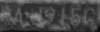

Image: 1
CER: 0.428571
Model Prediction: ['皖', '-', '-', '-', '-', 'A', '-', '-', '-', 'N', '-', '-', '8', '-', '-', '3', '-', '-', '-', '3', '-', '-', 'T', '-']
Label: 皖AN866B


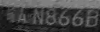

Image: 2
CER: 0.571429
Model Prediction: ['浙', '-', '-', '-', '-', '-', '1', '-', '-', '7', '-', '-', '-', 'Q', '-', '-', '0', '-', '-', 'M', '-', '-', '9', '-']
Label: 皖AMQ059


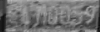

Image: 3
CER: 0.571429
Model Prediction: ['皖', '-', '-', '-', '-', 'A', '-', '-', '-', '-', 'A', '-', '-', '9', '-', '-', '-', '5', '-', '-', '-', '9', '-', '-']
Label: 皖AK927W


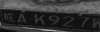

Image: 4
CER: 0.571429
Model Prediction: ['皖', '-', '-', '-', '-', 'A', '-', '-', '-', '4', '-', '-', 'W', '-', '-', '3', '-', '-', '5', '-', '-', '-', 'X', '-']
Label: 皖A2W003


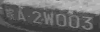

Image: 5
CER: 0.571429
Model Prediction: ['浙', '-', '-', '-', '-', 'A', '-', '-', '-', 'R', 'R', '-', '-', '1', '-', '-', 'Q', '-', '-', '7', '-', '-', '0', '-']
Label: 皖AB1930


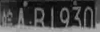

Image: 6
CER: 0.428571
Model Prediction: ['皖', '-', '-', '-', '-', '-', 'A', '-', '-', 'F', '-', '-', '8', '-', '-', '9', '-', '-', 'R', '-', '-', '7', '-', '-']
Label: 皖AF888S


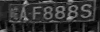

Image: 7
CER: 0.571429
Model Prediction: ['皖', '-', '-', '-', 'A', '-', '-', '8', '-', '-', 'H', '-', '3', '-', '-', '3', '-', '6', 'A', '-', '-', '-', '1', '-']
Label: 皖ABJ356


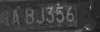

Image: 8
CER: 0.428571
Model Prediction: ['皖', '-', '-', '-', '-', 'A', '-', '-', '-', 'L', '-', '-', '-', '5', '-', '-', '7', '-', '-', 'Z', '-', '-', '7', '-']
Label: 皖ALG722


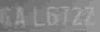

Image: 9
CER: 0.428571
Model Prediction: ['皖', '-', '-', '-', '-', '-', 'H', '-', '-', '-', 'Z', '-', '-', '1', '-', '2', '2', '-', 'V', '-', '-', '-', '1', '-']
Label: 鲁M712V1


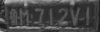

In [21]:
for i in range(len(metrics)):
    print('Image: {}\nCER: {:8f}\nModel Prediction: {}\nLabel: {}' \
          .format(i, metrics[i], preds[i], labels[i]))
    cv2_imshow(images[i])
    print('=' * 30)

Большинство ошибок в выделенных изображениях появляются из-за нечеткости изображения или наличия грязи/снега на номерах.

Попробовать решить данную проблему можно дообучением на таких данных. Еще можно немного улучшить контрастность символов с помощью библиотеки cv2.